<a href="https://colab.research.google.com/github/sohaibrabbani/image-classification-through-filter-bank/blob/main/image-classification-filter-bank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
# !git clone https://github.com/sohaibrabbani/image-classification-through-filter-bank.git
# !cp -r '/content/image-classification-through-filter-bank/.' '/content/'

In [57]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob

### Outline

In Part A, you will be implementing a function for 2D convoulution. You will be implementing the following functions:

- Convolution functions:
    - Zero Padding
    - Convolve Image

#### Zero-Padding

Zero-padding adds zeros around the border of an image:

The main benefits of padding are the following:

- It allows you to use a CONV layer without necessarily shrinking the height and width of the volumes. This is important for building deeper networks, since otherwise the height/width would shrink as you go to deeper layers. An important special case is the "same" convolution, in which the height/width is exactly preserved after one layer. 

- It helps us keep more of the information at the border of an image. Without padding, very few values at the next layer would be affected by pixels as the edges of an image.


Implement the <code>zero_pad</code> function which will pad the image. Use <code>np.pad</code> to do this (Look up the documentation to figure out the arguments for padding)

In [58]:
help(np.pad)

Help on function pad in module numpy:

pad(array, pad_width, mode='constant', **kwargs)
    Pad an array.
    
    Parameters
    ----------
    array : array_like of rank N
        The array to pad.
    pad_width : {sequence, array_like, int}
        Number of values padded to the edges of each axis.
        ((before_1, after_1), ... (before_N, after_N)) unique pad widths
        for each axis.
        ((before, after),) yields same before and after pad for each axis.
        (pad,) or int is a shortcut for before = after = pad width for all
        axes.
    mode : str or function, optional
        One of the following string values or a user supplied function.
    
        'constant' (default)
            Pads with a constant value.
        'edge'
            Pads with the edge values of array.
        'linear_ramp'
            Pads with the linear ramp between end_value and the
            array edge value.
        'maximum'
            Pads with the maximum value of all or part of

In [59]:
def zero_pad(X, pad):
    """
    Arguments:
    X -- python numpy array of shape (n_H, n_W) representing a an image
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    """
    X_pad = np.pad(X,(pad,pad),'constant',constant_values=(0))
    return X_pad

Shape of x_pad:  (7, 7)


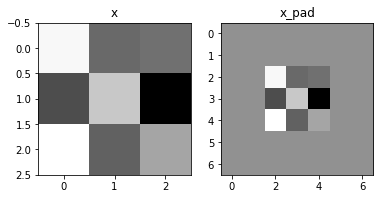

In [61]:
np.random.seed(1)
x = np.random.randn(3, 3)
x_pad = zero_pad(x, 2)

print("Shape of x_pad: ", x_pad.shape)

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x,cmap='gray')
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad,cmap='gray')

**Expected Output**:
<table>
    <tr>
        <td>
            <strong>x_pad.shape</strong>
        </td>
        <td>
            (7,7)
        </td>
    </tr>

</table>

#### 2D Convolution

In this part, implement a 2D convolution, in which you apply the filter to aa image. This will be used to build a convolutional unit, which: 

- Takes an input image 
- Applies a filter at every position of the input
- Outputs another image (usually of different size)

In [62]:
def conv2D(inp, F, pad, stride):
    """
    Arguments:
    inp -- output activations of the previous layer, numpy array of shape (n_H, n_W)
    F -- Filter, numpy array of shape (f, f)
    pad -- integer
    stride -- integer
    """
    
    # Retrieve dimensions from inp's shape
    (n_H, n_W) = inp.shape
    
    # Retrieve dimensions from F's shape
    (f, f) = F.shape
    
    ########## START CODE HERE ##########
    # Compute the dimensions of the CONV output volume (Hint: use int() to floor the output)
    n_H = int((((n_H-f) + (2*pad))/stride) + 1)
    n_W = int((((n_W-f) + (2*pad))/stride) + 1)
    
    # Initialize the output volume Z with zeros
    Z = np.zeros((n_H, n_W))
    
    # Create inp_pad by padding inp
    inp_pad = zero_pad(inp, pad)

    # Iterate over inp and compute its Convolved output (z) and store it appropriately in Z.
    
    # Loop over every pixel of the image
    
    for x in range(n_W):
        for y in range(n_H):
            # element-wise multiplication of the kernel and the image
            Z[y, x] = (F * inp_pad[y: y+f, x: x+f]).sum()
    ########## END CODE HERE ##########
    
    return Z

#### Edge Detection

(496, 661, 3)


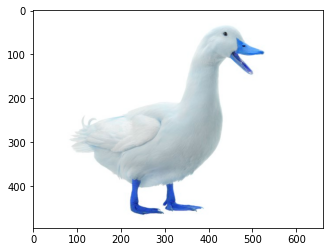

In [64]:
# read and display duck.jpg (Hint: for reading image see cv2.imread)
duck= cv2.imread('duck.jpg')
print(duck.shape)
plt.imshow(duck)

(496, 661)


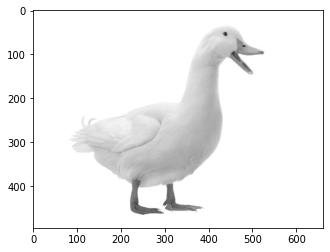

In [65]:
# convert duck to grayscale (Hint: see cv2.cvtColor)
duck_gray= cv2.cvtColor(duck, cv2.COLOR_BGR2GRAY)
print(duck_gray.shape)
plt.imshow(duck_gray,cmap='gray')

(496, 661)


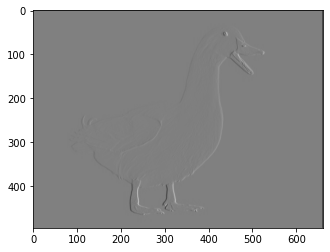

In [66]:
# Initialize sobel horizontal edge filter
h_filter= np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype = np.float)

h_edges = conv2D(duck_gray, h_filter, 1, 1)
print(duck_gray.shape)
plt.imshow(h_edges, cmap='gray')
# plt.imshow(h_edges)
# Use your Conv2D filter to get horizontal edges and display them.


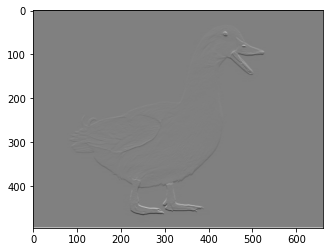

In [74]:
# Initialize sobel vertical edge filter
v_filter= np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype = np.float)

# Use your Conv2D filter to get vertical edges and display them.
v_edges = conv2D(duck_gray, v_filter, 1, 1)
plt.imshow(v_edges, cmap='gray')


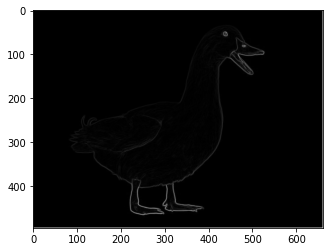

In [79]:
# Combine horizontal and vertical edges and display the final results
combined_edges = np.sqrt((h_edges)**2 + (v_edges)**2)
plt.imshow(combined_edges, cmap = 'gray')

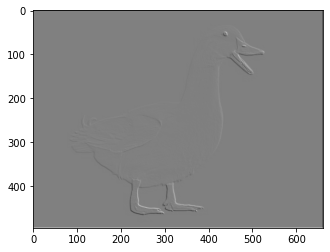

In [77]:
plt.imshow(h_edges + v_edges, cmap='gray')

#### Filter Bank

In this part you will make a filter bank for skin textures given in skins folder and then use those to classify 'unknown.jpg'. You will perform the following steps:

- Read skin images and convert them to grayscale.
- Resize the images to 64x64. (Hint: see cv2.resize).
- Initialize any 6 filters. This will be your filter bank. See slide 60 of Lec3 to see which filters can be used.
- Create a 6D feature vector for each image (See Lec3 slides for reference) using window size of 8. (Use your Conv2D function for this).
- Display each feature vector as an image i.e. use plt.imshow.
- Do the above steps for unknown.jpg and calculate it's feature vector.
- Calculate and display the equilidean distance of unknown.jpg's feature with each of skin's feature vector.
- Predict the class name of unknown.jpg based on the euclidean distances calculated in previous step.

In [70]:
def get_filter_bank():
  filter_bank = []
  sobel_vertical = np.array([[-1, 0, 1],
                             [-2, 0, 2],
                             [-1, 0, 1]])
  filter_bank.append(sobel_vertical)
  
  sobel_horizontal = np.flip(sobel_vertical.T, axis=0)
  filter_bank.append(sobel_horizontal)
                     
  roberts_vertical = np.array([[0, 0, -1],
                             [0, 1, 0],
                             [0, 0, 0]])
  filter_bank.append(roberts_vertical)

  averaging = np.ones([3, 3], dtype = int) 
  averaging / averaging / 9
  filter_bank.append(averaging)

  high_pass = np.array([[-1 / 9, -1 / 9, -1 / 9],
              [-1 / 9, 8 / 9, -1 / 9],
              [-1 / 9, -1 / 9, -1 / 9]])
  filter_bank.append(high_pass)

  sharpening = np.array([[0, -1, 0],
                         [-1, 8, -1],
                         [0, -1, 0]])
  sharpening = sharpening / 4
  filter_bank.append(sharpening)

  return filter_bank

In [71]:
def get_feature_vector(image, filter_bank, image_size, window_size, pad, stride):
  feature_vector = np.zeros((len(filter_bank), int((image_size/window_size) * (image_size/window_size))))
  for idx, filter in enumerate(filter_bank):
    window_number = 0
    for i in range(0, image_size, window_size):
      for j in range(0, image_size, window_size):
        feature_vector[idx, window_number] = np.max(conv2D(image[i:i+window_size, j:j+window_size], filter, pad = pad, stride = stride))
        window_number += 1
  return feature_vector

leopard 
 2341.7570840590492 

tiger 
 2653.1540250924363 

cheetah 
 2044.226168337255 

jaguar 
 3342.5364218631157 

giraffe 
 2910.172456415641 


Predicted class:  cheetah 



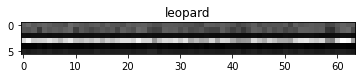

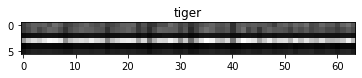

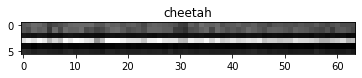

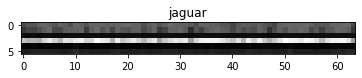

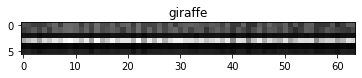

In [72]:
distances = []
images = []
window_size = 8
image_size = 64
pad = 1
stride = 1

# Initialize any 6 filters. This will be your filter bank. See slide 60 of Lec3 to see which filters can be used.
filter_bank = get_filter_bank()

for image_path in glob.glob("skins/*.jpg"):
  image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
  image = cv2.resize(image,(64,64))
  
# Create a 6D feature vector for each image using window size of 8
  fv = get_feature_vector(image, filter_bank, image_size, window_size, pad, stride)    
  images.append((image_path.split('/')[-1].split('.')[0], fv))  

# Display each feature vector as an image i.e. use plt.imshow.
for image in images:
  plt.figure()
  plt.imshow(image[1], cmap='gray')
  plt.title(image[0])

# Doing the above steps for unknown.jpg and calculate it's feature vector.
img = cv2.imread('/content/unknown.jpg',cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img,(64,64))
fv = get_feature_vector(img, filter_bank, image_size, window_size, pad, stride)


# Calculate and display the equilidean distance of unknown.jpg's feature with each of skin's feature vector.
for image in images:
  euclidean_distance = np.sqrt(np.square(fv - image[1]).sum())
  distances.append((image[0], euclidean_distance))
  print(image[0], '\n', euclidean_distance, '\n')

# Predict the class name of unknown.jpg based on the euclidean distances calculated in previous step.
print("\nPredicted class: ", min(distances, key = lambda x: x[1])[0],'\n')


In [73]:
import numpy as np
from sklearn.model_selection import train_test_split

np.arange(10)
dataset_indexes = np.arange(2400)

# trainval, test, __, _t = train_test_split(dataset_indexes, dataset_indexes, test_size=.05)
# train, val, __, _t = train_test_split(trainval, trainval, test_size=0.05)
# print(trainval.shape, train.shape, test.shape, val.shape)
label = [np.zeros((6,)),np.zeros((6,))]
np.array(label)

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])